# To generate the plots in Figure 4c of the paper

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
from matplotlib import rc
from copy import deepcopy
rc('text', usetex=False)
from cycler import cycler
import palettable
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [4]:
def convert_X_to_n(X):
    binvec = (1 - X)/2
    binvec= binvec.astype(int)
    n = np.sum((2**np.arange(len(X)))*binvec)
    return n

def generate_module_weights(n_m):
    return np.random.randn(2**n_m)

def get_module_output(weights,X, Ks):
    n = (1 - X)/2
    n = n.astype(int)
    coeffs = (-1)**np.matmul(Ks,n.T)
    
    return np.sum(coeffs*weights[:,None],axis=0)

def generate_modules(mus, M, maxn_m):
    p = len(mus)
    weights = []
    loci = []
    for m in range(M):
        n_m = 0
        selected_m = []
        while n_m > maxn_m or n_m < 1:
            locs = np.arange(p)
            selected_m = locs[np.random.uniform(size = p) < mus]
            n_m = len(selected_m)
        weights += [generate_module_weights(n_m)/np.sqrt(M)]
        loci += [selected_m]
    return weights, loci

def get_Ks_all(maxn_m):
    Ks_all = []
    for n_m in range(maxn_m+1):
        Ks = np.zeros((2**n_m, n_m),dtype = int)
        for i in range(Ks.shape[0]):
            Ks[i] = np.array([int(ii) for ii in bin(i)[2:].zfill(n_m)])
            
        Ks_all += [Ks]
    return Ks_all

def get_fitness(weights,loci,X, Ks_all):
    fitness = 0
    for m in range(M):
        n_m = len(loci[m])
        Ks = Ks_all[n_m]
            
        fitness += get_module_output(weights[m],X[:,loci[m]], Ks)
        
    return fitness

def dist(s,f,vbar):
    return np.exp(-s*f/2 - np.abs(s)*np.sqrt(2/vbar + f**2)/2)/(2*vbar*np.sqrt(2/vbar + f**2))    

In [5]:
#CN model parameters

mu = 0.02
p = int(8/mu)
mus = np.random.exponential(mu, size = p)
print(p)
M = 500
maxn_m = 14 #max epistatic order
weights,loci = generate_modules(mus, M, maxn_m)
Ks_all = get_Ks_all(maxn_m)

400


In [6]:
#Normalize weights in the model so that total variance is one. 

n_ms = [len(loci[m]) for m in range(len(loci))]
print(np.mean(n_ms),np.std(n_ms),np.max(n_ms))

Vloci = np.zeros(p)
V = 0
for m in range(len(weights)):
    n_m = len(loci[m])
    Ks = Ks_all[n_m]
    V += np.sum(weights[m][1:]**2)
    for i in range(n_m):
        filt = (Ks[:,i] == 1)
        Vloci[loci[m][i]] += np.sum(weights[m][np.arange(2**n_m)[filt]]**2)
Vloci /= V

#Normalize weights
for m in range(len(weights)):
    weights[m] /= np.sqrt(V)

7.474 2.702836288050018 14


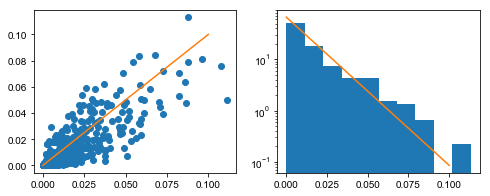

In [7]:
plt.close("all")
fig,axis = plt.subplots(1,2,figsize= (8,3))
axis[0].plot(mus/(1+mu),Vloci,'o')
axis[1].hist(Vloci, density = True)
xs = np.linspace(0,mu*5,200)
axis[0].plot(xs,xs)
axis[1].semilogy(xs, np.exp(-xs/np.mean(Vloci))/np.mean(Vloci))
plt.show()

In [9]:
#Simulate an evolutionary trajectory

def evolve(genos, fitness, weights, loci, Ks_all):
    evolved = []
    Yevol = []
    Ys = get_fitness(weights,loci,genos, Ks_all)
    fixlocis = []
    for ind in range(len(genos)):
        founder = genos[ind]
        nsteps = 30
        curr = deepcopy(founder)
        Ycurr = Ys[ind]

        times = []
        fixloci = []
        Ytraj = []
        ntime = 0
        vselected = []
        for i in range(nsteps):
            select = 0
            if Ycurr > fitness:
                evolved += [curr]
                Yevol += [deepcopy(Ycurr)]
                break
            while select == 0:
                ntime += 1
                temp = deepcopy(curr)
                locus = np.random.choice(p)
                temp[locus] *= -1
                Ynew = get_fitness(weights,loci,temp[None,:], Ks_all)[0]
                s = Ynew - Ycurr
                if np.random.uniform() < 2*s*1:
                    select = 1
                    Ycurr = Ynew
                    curr = deepcopy(temp)
                    fixloci += [locus]
                    times += [ntime]
                    Ytraj += [Ycurr]
                    vselected += [Vloci[locus]]
        print("%d %.3f %.3f %d" %(ind, Ycurr, Ys[ind], i))
        fixlocis += [fixloci]
    return np.array(evolved), np.array(Yevol),fixlocis

In [10]:
#Generate n random genotypes and evolve them to y ~ 3 and y ~ 5.

n = 128
bgs = 2*(np.random.randn(n,p) > 0) - 1
Ys = get_fitness(weights,loci,bgs, Ks_all)

evolved1, Yevol1,fixlocis1 = evolve(bgs, 2.25, weights, loci, Ks_all)
evolved2, Yevol2,fixlocis2 = evolve(bgs, 4.75, weights, loci, Ks_all)

0 2.360 -0.764 8
1 2.258 0.778 10
2 2.271 -0.049 6
3 2.515 -0.209 8
4 2.293 -1.248 14
5 2.253 0.019 5
6 2.566 1.476 4
7 2.499 1.243 4
8 2.296 0.570 10
9 2.409 0.182 8
10 2.284 -0.869 12
11 2.788 -0.215 5
12 2.982 0.690 5
13 2.262 1.203 3
14 2.289 0.423 8
15 2.496 -0.223 11
16 2.281 1.683 2
17 2.346 0.681 4
18 2.385 1.207 4
19 2.316 0.353 6
20 2.460 0.966 6
21 2.299 -0.900 12
22 2.357 0.704 7
23 2.519 1.397 3
24 2.254 0.127 10
25 2.308 0.667 6
26 2.523 -0.642 7
27 2.273 1.250 5
28 2.567 0.365 7
29 2.255 -0.538 12
30 2.721 0.535 6
31 2.290 1.068 4
32 2.325 1.486 2
33 2.380 1.884 2
34 2.410 -0.545 8
35 2.556 -0.530 10
36 2.636 -0.430 9
37 2.622 -0.076 5
38 2.449 1.242 4
39 3.054 -0.190 12
40 2.509 1.036 4
41 2.360 -1.277 10
42 2.297 1.047 4
43 2.282 -0.529 9
44 2.376 0.036 9
45 2.792 -0.270 9
46 2.462 -0.822 10
47 2.346 0.650 6
48 2.383 -1.334 14
49 2.397 -0.370 10
50 2.515 0.858 5
51 2.322 -0.184 6
52 2.393 -0.516 13
53 2.255 1.381 4
54 2.296 0.961 7
55 2.483 -1.129 10
56 2.314 0.672 5
5

In [11]:
#To compute the DFE, pick random 200 sites and mutate them. 

Nmuts = 200

mutloci = np.random.choice(p, size= Nmuts, replace= False)

Nmuts = len(mutloci)

Yevol1_muts = np.zeros((Nmuts,len(evolved1)))
Yevol2_muts = np.zeros((Nmuts,len(evolved2)))
for i in range(Nmuts):
    if i%25 == 0:
        print(i)
    muts = deepcopy(evolved1)
    muts[:,mutloci[i]] *= -1 
    Yevol1_muts[i] = get_fitness(weights,loci,muts, Ks_all)
    
    muts = deepcopy(evolved2)
    muts[:,mutloci[i]] *= -1 
    Yevol2_muts[i] = get_fitness(weights,loci,muts, Ks_all)

0
25
50
75
100
125
150
175


In [12]:
#This is for the y = 0 genotypes

Ymuts = np.zeros((Nmuts,len(bgs)))
for i in range(Nmuts):
    if i%25 == 0:
        print(i)
    muts = deepcopy(bgs)
    muts[:,mutloci[i]] *= -1 
    Ymuts[i] = get_fitness(weights,loci,muts, Ks_all)

0
25
50
75
100
125
150
175


88


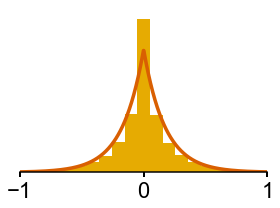

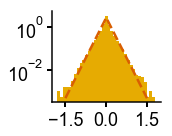

In [13]:
#Plot DFE for Y=0

dfes = Ymuts - Ys
plt.rc('axes', prop_cycle=(cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)))

f = 0
inds = np.arange(len(Ys))[(Ys > f - 1)*(Ys < f + 1)]
print(len(inds))


plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3))
axis.hist(dfes[:,inds].flatten(), bins = np.linspace(-2,2,40), density = True, color = 'C5')

xs = np.linspace(-1.5,1.5,1000)
vbar = np.mean(Vloci)

axis.plot(xs, dist(xs, f , vbar), 'C1-', lw = 3.5)
axis.set_xlim(-1,1)
axis.set_yticks([])
axis.set_xticks([-1,0,1])
#axis.set_xlabel(r"Fitness effect (s)",fontsize = 20)
axis.tick_params(labelsize = 22, width = 2, size = 5)

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(0)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfe_y0_sim.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (2.5,2))
axis.hist(dfes[:,inds].flatten(), bins = np.linspace(-2,2,40), density = True, color = 'C5')

xs = np.linspace(-1.5,1.5,1000)
vbar = np.mean(Vloci)

axis.semilogy(xs, dist(xs, f , vbar), 'C1--', lw = 2.5)
axis.set_xlim(-2,2)
#axis.set_yticks([])
axis.set_xticks([-1.5,0,1.5])
#axis.set_xlabel(r"Fitness effect (s)",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
axis.minorticks_off()
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfe_y0_sim_inset.pdf")
plt.show()

119


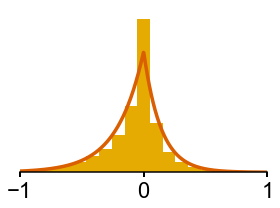

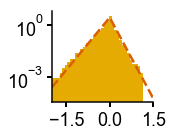

In [14]:
#Plot DFE for Y=2.5

dfes = Yevol1_muts - Yevol1

f = 2.5
inds = np.arange(len(Yevol1))[(Yevol1 > f - 0.25)*(Yevol1 < f + 0.25)]
print(len(inds))

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3))
axis.hist(dfes[:,inds].flatten(), bins = np.linspace(-2,2,40), density = True, color = 'C5')

xs = np.linspace(-1.5,1.5,1000)
vbar = np.mean(Vloci)

axis.plot(xs, dist(xs, f , vbar), 'C1-', lw = 3.5)
axis.set_xlim(-1,1)
axis.set_yticks([])
axis.set_xticks([-1,0,1])
#axis.set_xlabel(r"Fitness effect (s)",fontsize = 20)
axis.tick_params(labelsize = 22, width = 2, size = 5)

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(0)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfe_y2_5_sim.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (2.5,2))
axis.hist(dfes[:,inds].flatten(), bins = np.linspace(-2,1.5,40), density = True, color = 'C5')

xs = np.linspace(-2,1.5,1000)
vbar = np.mean(Vloci)

axis.semilogy(xs, dist(xs, f , vbar), 'C1--', lw = 2.5)
axis.set_xlim(-2,1.5)
axis.set_yticks([1e-3,1e0])
axis.set_xticks([-1.5,0,1.5])
#axis.set_xlabel(r"Fitness effect (s)",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
axis.minorticks_off()
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfe_y2_5_sim_inset.pdf")
plt.show()

121


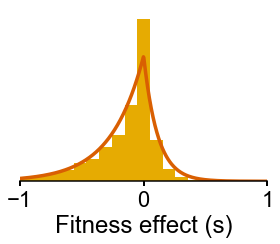

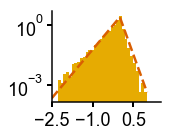

In [15]:
#Plot DFE for Y=5

dfes = Yevol2_muts - Yevol2

f = 5
inds = np.arange(len(Yevol2))[(Yevol2 > f - 0.25)*(Yevol2 < f + 0.25)]
print(len(inds))
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3.5))
axis.hist(dfes[:,inds].flatten(), bins = np.linspace(-2,2,40), density = True, color = 'C5')

xs = np.linspace(-1.5,1.5,1000)
vbar = np.mean(Vloci)

axis.plot(xs, dist(xs, f , vbar), 'C1-', lw = 3.5)
axis.set_xlim(-1,1)
axis.set_yticks([])
axis.set_xticks([-1,0,1])
axis.set_xlabel(r"Fitness effect (s)",fontsize = 24)
axis.tick_params(labelsize = 22, width = 2, size = 5)

axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(0)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfe_y5_sim.pdf")
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (2.5,2))
axis.hist(dfes[:,inds].flatten(), bins = np.linspace(-3,1,40), density = True, color = 'C5')

xs = np.linspace(-2.5,1,1000)
vbar = np.mean(Vloci)

axis.semilogy(xs, dist(xs, f , vbar), 'C1--', lw = 2.5)
axis.set_xlim(-2,1.5)
axis.set_yticks([1e-3,1e0])
axis.set_xticks([-2.5,-1,0.5])
#axis.set_xlabel(r"Fitness effect (s)",fontsize = 20)
axis.tick_params(labelsize = 18, width = 2, size = 5)
axis.minorticks_off()
axis.spines['top'].set_linewidth(0)
axis.spines['left'].set_linewidth(1.5)
axis.spines['bottom'].set_linewidth(1.5)
axis.spines['right'].set_linewidth(0)
fig.tight_layout()
fig.savefig("./RandomQTL_Plots/dfe_y5_sim_inset.pdf")
plt.show()